### 동적모델 클래스 생성
- 커스텀 모델 생성
- 은닉층 개수 & 입력층 출력층 은닉층 input,output => 동적
<br>
- 학습목표:	iris 품종 분류
- 알고리즘: 다중 분류 

#####  다중분류 => one_hot_encoding 불가!!
- 이유) crossentropyLoss 공식 API에서 라벨 인코딩 버전만 허용함을 명시함
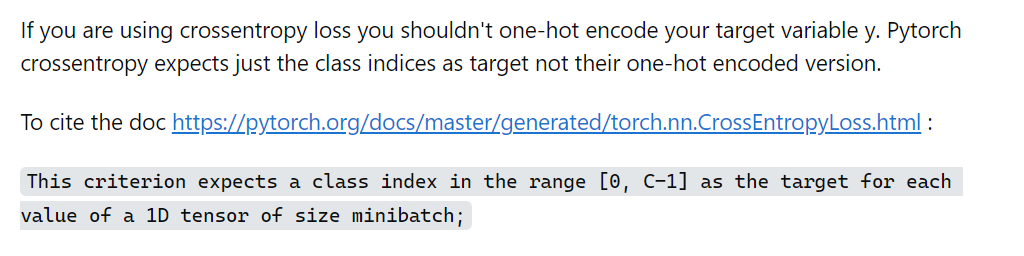

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary

from torch.utils.data import Dataset, DataLoader

import pandas as pd
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

#### [1] 데이터 로드

In [2]:
DATA_FILE = r'C:\Users\KDP-43\Desktop\머신러닝_1\data\iris.csv'

irisDF = pd.read_csv(DATA_FILE)
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


##### 타겟 변수 인코딩
- Iris 품종 3개
- 인코더: onehotencoder

In [3]:
# 피쳐 & 타겟
featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[[irisDF.columns[-1]]]

print(f'featureDF:	{featureDF.shape}')
print(f'targetDF:	{targetDF.shape}')

featureDF:	(150, 4)
targetDF:	(150, 1)


In [4]:
# 타겟 변수 인코딩
# 0-> {}, 1-> {}, 2-> {}
label_data = irisDF['variety'].unique().tolist()
labels = dict(zip(label_data, range(len(label_data))))
print(labels)

irisDF['variety_encd'] = irisDF['variety'].replace(labels)

{'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


In [5]:
irisDF.columns

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width', 'variety',
       'variety_encd'],
      dtype='object')

In [6]:
# 피쳐 & 타겟
featureDF = irisDF[irisDF.columns[:4]]
targetDF = irisDF[[irisDF.columns[-1]]]

print(f'featureDF:	{featureDF.shape}')
print(f'targetDF:	{targetDF.shape}')

featureDF:	(150, 4)
targetDF:	(150, 1)


In [7]:
## 타겟 변수 인코딩
## 다중분류 crossEntroypLoss는  one_hot 인코딩 타겟 변수 입력 불가!!
# encoder = OneHotEncoder(sparse_output=False)
# encoder.fit(targetDF)
# targetOHE = encoder.transform(targetDF)

# targetEn_DF = pd.DataFrame(targetOHE, columns=[irisDF['variety'].unique().tolist()])

# print()
# print(targetOHE.shape)
# print(targetOHE[ [0, 51, 101] ])
# print(targetEn_DF)
# print(type(targetEn_DF))

In [8]:
# Train, test, valid
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF,
                                                    test_size=0.2 ,
                                                    stratify=targetDF,
                                                    random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, 
                                                  stratify=y_train,
                                                  random_state=10)

print()
print(f'X_trian: {X_train.shape} {X_train.ndim}D')
print(f'y_trian: {y_train.shape} {y_train.ndim}D')
print(f'X_val: {X_val.shape} {X_val.ndim}D')
print(f'y_val: {y_val.shape} {y_val.ndim}D')
print(f'X_test: {X_test.shape} {X_test.ndim}D')
print(f'y_test: {y_test.shape} {y_test.ndim}D')


X_trian: (96, 4) 2D
y_trian: (96, 1) 2D
X_val: (24, 4) 2D
y_val: (24, 1) 2D
X_test: (30, 4) 2D
y_test: (30, 1) 2D


#### 사용자 정의 동적 모델 클래스_1
- 클래스이름: DynamicModel()
- 부모클래스: nn.Module
- 기능_속성: init(), forward()
- 매개_변수: in_in(입력층_input), out_out(출력층_output)
			h_inout(은닉층_input&output), h_cnt(은닉층 개수)
- 클래스 구조:
	* 입력층 & 출력층 입출력 개수 동적		
	* 은닉층의 개수 -> 동적 
	* 은닉층 퍼셉트론 개수 -> 고정
	* AF: ReLU()

In [9]:
# 랜덤 고정
torch.manual_seed(1)

# 텐서 저장 및 실행 위치 고정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
class DynamicModel(nn.Module):
    
	# 모델 구조 설계 -> 생성자 메서드
	def __init__(self,in_in,out_out,h_inout,h_cnt):
		super().__init__()

		self.in_layer = nn.Linear(in_in, h_inout)
		self.hd_layers = nn.ModuleList( [nn.Linear(h_inout,h_inout) for _ in range(h_cnt)])
		self.out_layer = nn.Linear(h_inout, out_out)

	# 학습 진행 콜백 메서드
	def forward(self, x):
		y = F.relu( self.in_layer(x) )
		
		for linear in self.hd_layers:
			y = F.relu(linear(y))

		return self.out_layer(y)
	

In [11]:
# 테스트
# 커스텀 클래스 인스턴스 생성
model = DynamicModel(in_in=4, out_out=3, h_inout=10, h_cnt=5)

# print(model)
# print()
# summary(model, input_size=(150,4))


In [12]:
# 모델 파라미터 확인
for name, param in model.named_parameters():
    print(name, param)
    break

in_layer.weight Parameter containing:
tensor([[ 0.2576, -0.2207, -0.0969,  0.2347],
        [-0.4707,  0.2999, -0.1029,  0.2544],
        [ 0.0695, -0.0612,  0.1387,  0.0247],
        [ 0.1826, -0.1949, -0.0365, -0.0450],
        [ 0.0725, -0.0020,  0.4371,  0.1556],
        [-0.1862, -0.3020, -0.0838, -0.2157],
        [-0.1602,  0.0239,  0.2981,  0.2718],
        [-0.4888,  0.3100,  0.1397,  0.4743],
        [ 0.3300, -0.4556, -0.4754, -0.2412],
        [ 0.4391, -0.0833,  0.2140, -0.2324]], requires_grad=True)


#### 사용자 정의 동적 모델 클래스_2
- 클래스이름: Dynamic2Model
- 부모클래스: nn.Module
- 기능_속성: init(), forward()
- 매개_변수: in_in, in_out, out_out, h_in=[], h_out=[], h_cnt
- 클래스 구조:
	* 입력층 & 출력층 입출력 개수	-> 동적
	* 은닉층 개수	-> 동적
	* 퍼셉트론 개수	-> 동적 (각 은닉층 마다 다른)

In [13]:
class DynamicModel2(nn.Module):
    
	def __init__(self, in_in, in_out, out_out, h_in=[], h_out=[] ):

		super().__init__()

		self.in_layer = nn.Linear(in_in, h_in[0] if len(h_in) else in_out)
		self.hd_layers = nn.ModuleList()

		for idx in range(len(h_in)):
			self.hd_layers.append(nn.Linear(h_in[idx], h_out[idx])) 

		self.out_layer = nn.Linear(h_out[-1] if len(h_in) else in_out, 
							 out_out)

	def forward(self, x):
		# 입력층
		y = self.in_layer(x)
		y = F.relu(y)

		# 은닉층
		for linear in self.hd_layers:
			y = F.relu( linear(y))

		# 출력층

		return self.out_layer(y)
		


In [14]:
# 테스트
h_in_, h_out_ = [10,20,30], [20,30,10]
model2 = DynamicModel2(in_in=3, in_out=5, out_out=3, 
                       h_in=h_in_, h_out=h_out_)

print(model2)

DynamicModel2(
  (in_layer): Linear(in_features=3, out_features=10, bias=True)
  (hd_layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
  (out_layer): Linear(in_features=10, out_features=3, bias=True)
)


In [15]:
# 커스텀 데이터셋
class IrisDataset(Dataset):
    
	def __init__(self, featureDF, targetDF):
		super().__init__()

		self.featureDF = featureDF
		self.targetDF = targetDF
		self.n_rows = featureDF.shape[0]
		self.n_features = featureDF.shape[1]

	def __len__(self):
		return self.n_rows
	
	def __getitem__(self, idx):
		featureTS = torch.FloatTensor( self.featureDF.iloc[idx].values)
		targetTS = torch.FloatTensor( self.targetDF.iloc[idx].values)

		return featureTS, targetTS

In [16]:
# 커스텀 데이터셋 클래스 테스트
irisDS = IrisDataset(featureDF, targetDF)

for data, label in irisDS:
    print(data, label)
    break

tensor([5.1000, 3.5000, 1.4000, 0.2000]) tensor([0.])


In [17]:
# train, test, val DS 생성
trainDS = IrisDataset(X_train, y_train)
testDS = IrisDataset(X_test, y_test)
valDS = IrisDataset(X_val, y_val)


#### 학습준비

In [18]:
# 모델 하이퍼 파라미터 설정
EPOCH = 100
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

# 최적화 함수
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수
clfLoss = nn.CrossEntropyLoss()
# 성능지표 함수
scoreFunc = MulticlassF1Score(num_classes=3)

In [19]:
print(model.named_children)

<bound method Module.named_children of DynamicModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hd_layers): ModuleList(
    (0-4): 5 x Linear(in_features=10, out_features=10, bias=True)
  )
  (out_layer): Linear(in_features=10, out_features=3, bias=True)
)>


In [20]:
print(model2.named_parameters)

<bound method Module.named_parameters of DynamicModel2(
  (in_layer): Linear(in_features=3, out_features=10, bias=True)
  (hd_layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
  (out_layer): Linear(in_features=10, out_features=3, bias=True)
)>


#### 학습

In [21]:
LOSS_history = {'Train':[], 'Val':[] }
SCORE_history = {'Train':[], 'Val':[] }

for ep in range(EPOCH):
    
	loss_tot=0
	score_tot=0

	# 모델 학습 모드 전환
	model.train()
	# model2.train()
	for featureTS, targetTS in DataLoader(trainDS, batch_size=BATCH_SIZE):

		BATCH_CNT = featureTS.shape[0]

		pre_y = model(featureTS)

		# print("targetTS: ", targetTS.shape)
		# print("targetTS.reshape(-1)", targetTS.reshape(-1).shape)
		
		loss = clfLoss(pre_y, targetTS.reshape(-1).long())
		# loss = clfLoss(pre_y, targetTS)
		# print("loss\n", loss, type(loss))
		# break
		loss_tot+=loss.item()

		score = scoreFunc(pre_y, targetTS.reshape(-1))
		score_tot += score.item()

		# weight, bias 업데이트
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	# 모델 검증 모드 전환
	model.eval()

	with torch.no_grad():

		val_featTS = torch.FloatTensor(valDS.featureDF.values)
		val_targTS = torch.FloatTensor(valDS.targetDF.values)

		pre_val = model(val_featTS)

		loss_val = clfLoss(pre_val, val_targTS.reshape(-1).long())

		score_val = scoreFunc(pre_val, val_targTS.reshape(-1))

	# 한 에포크 당 손실값과 성능평가값 저장
	LOSS_history['Train'].append(loss_tot/BATCH_CNT)
	SCORE_history['Train'].append(score_tot/BATCH_CNT)

	LOSS_history['Val'].append(loss_val)
	SCORE_history['Val'].append(score_val)

if ep%20 == 0:
		print(f"[{ep}/{EPOCH}]\n- [Train] LOSS: {LOSS_history['Train'][-1]:.5f} Score: {SCORE_history['Train'][-1]:.5f}")
		print(f"- [Valid] LOSS: {LOSS_history['Val'][-1]:.5f} Score: {LOSS_history['Val'][-1]:.5f}")

		


Text(0.5, 1.0, 'MULTI Classifi SCORE')

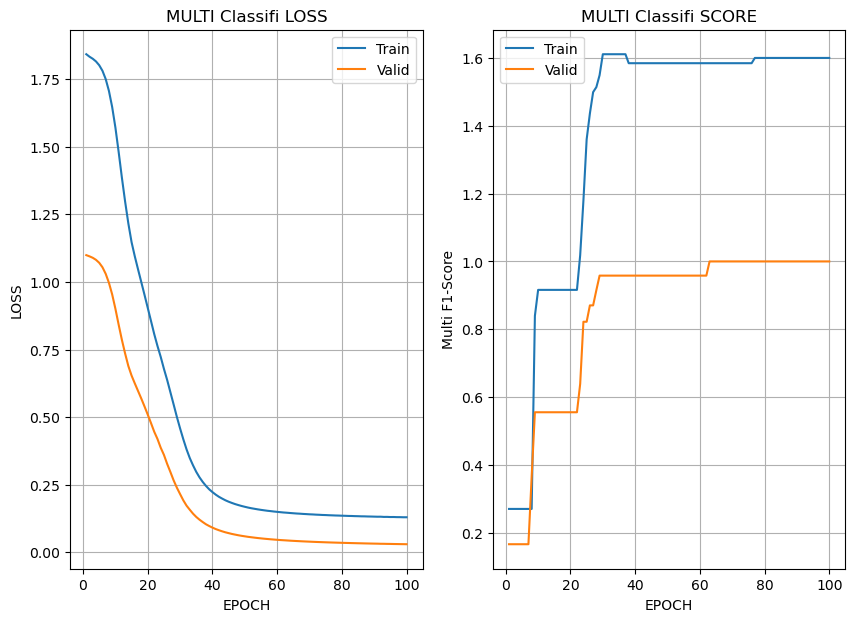

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,7))

axes[0].plot(range(1,EPOCH+1), LOSS_history['Train'], label='Train')
axes[0].plot(range(1,EPOCH+1), LOSS_history['Val'], label='Valid')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('LOSS')
axes[0].set_title('MULTI Classifi LOSS')

axes[1].plot(range(1,EPOCH+1), SCORE_history['Train'], label='Train')
axes[1].plot(range(1,EPOCH+1), SCORE_history['Val'], label='Valid')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('Multi F1-Score')
axes[1].set_title('MULTI Classifi SCORE')